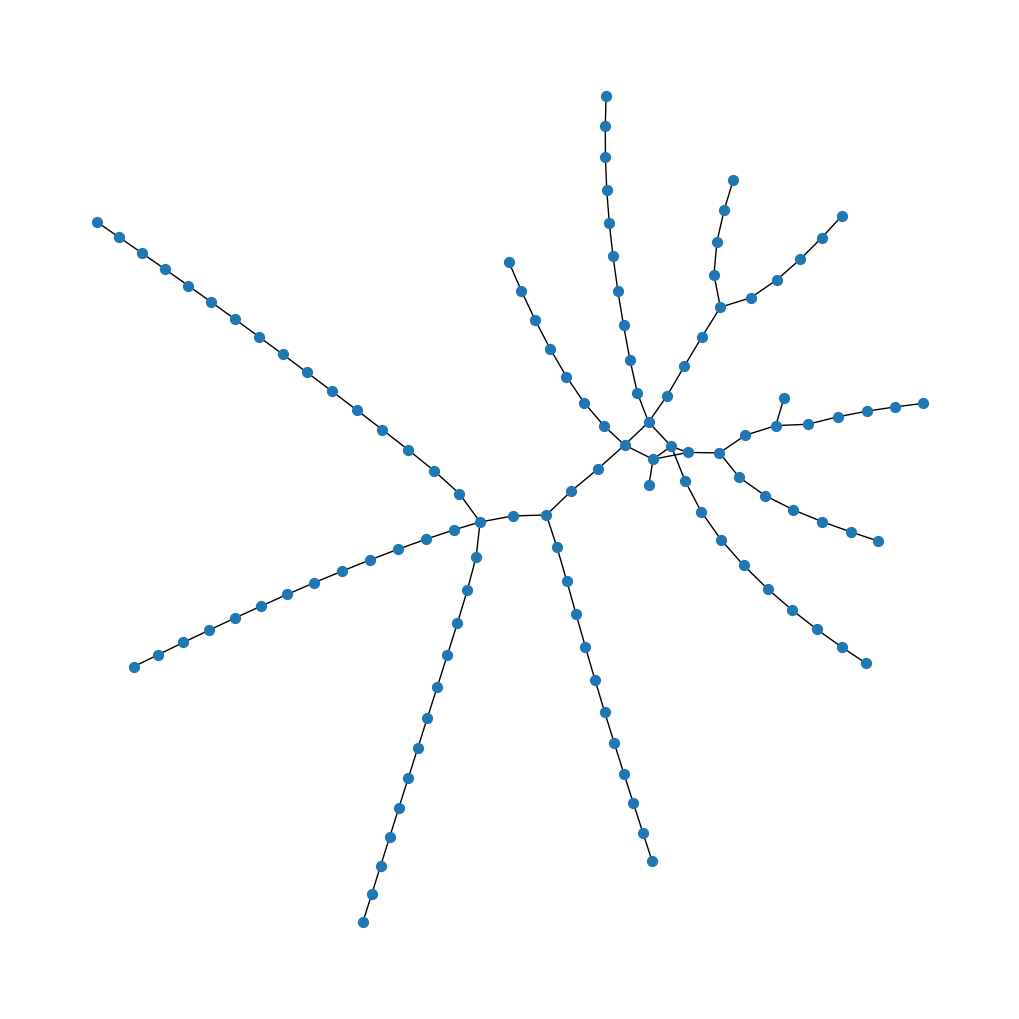

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def open_line_file(filename):
    with open(f'./lines_from_gtfs_static_data/{filename}.txt', 'r') as f:
      lines = f.readlines()
    return lines

line_files = [
    'Red-C1-0',
    'Red-C1-1',
    'Red-C2-0',
    'Red-C2-1',
    'Green-B-C1-0',
    'Green-B-C1-1',
    'Green-C-C1-0',
    'Green-C-C1-1',
    'Green-D-C1-0',
    'Green-D-C1-1',
    'Green-E-C1-0',
    'Green-E-C1-1',
    'Orange-C1-0',
    'Orange-C1-1',
    'Blue-C1-0',
    'Blue-C1-1'
]

line_stations = map(open_line_file, line_files)

stations = set()
edges = set()

for line in line_stations:
    for i in range(len(line)-1):
        stop_name = line[i].rstrip()
        next_stop_name = line[i+1].rstrip()
        stations.add(stop_name)
        edges.add((stop_name, next_stop_name))
    end_stop_name = line[-1].rstrip()
    stations.add(end_stop_name)

network = nx.Graph()
network.add_nodes_from(stations)
network.add_edges_from(edges)

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw(network, layout, node_size=50)

In [ ]:
import json

delays_file = open("/home/mark/school/math168/project/delay_data/named_rapid_transit_delays.json", 'r')
delays_json = delays_file.read()
delays_file.close()

delays = json.loads(delays_json)
delays

nx.set_node_attributes(network, delays, "avg_delay")
nx.get_node_attributes(network, "avg_delay")

{'Shawmut': -83440.0,
 'Orient Heights': -41.75,
 'Sutherland Road': -301.833333333333,
 'Copley': -165.083333333333,
 'Beaconsfield': -142.5,
 'Downtown Crossing': 123.142857142857,
 'Longwood Medical Area': -898.5,
 'Dean Road': 48.0,
 'Riverway': -884.0,
 'Kenmore': 28.5,
 'Washington Street': -360.8,
 'Quincy Center': -87075.0,
 'Bowdoin': -77.75,
 'Broadway': -14039.3333333333,
 'Newton Centre': 3.2,
 'Kent Street': 96.0,
 'Braintree': -86290.0,
 'Gilman Square': -9638.22222222222,
 'Cleveland Circle': 25.0,
 'Summit Avenue': 18.0,
 'Boylston': -151.5,
 'Sullivan Square': 13.1666666666667,
 'JFK/UMass': -42897.75,
 'East Somerville': -10859.75,
 'Back Bay': 28.1428571428571,
 'Boston University East': -174.0,
 'Brandon Hall': 34.0,
 'Wollaston': -86775.0,
 'Charles/MGH': 324.666666666667,
 'Kendall/MIT': 277.666666666667,
 'Roxbury Crossing': -10796.125,
 'State': -65.75,
 'North Station': -264.5,
 'Museum of Fine Arts': -1085.0,
 'Stony Brook': -9544.11111111111,
 'Jackson Square

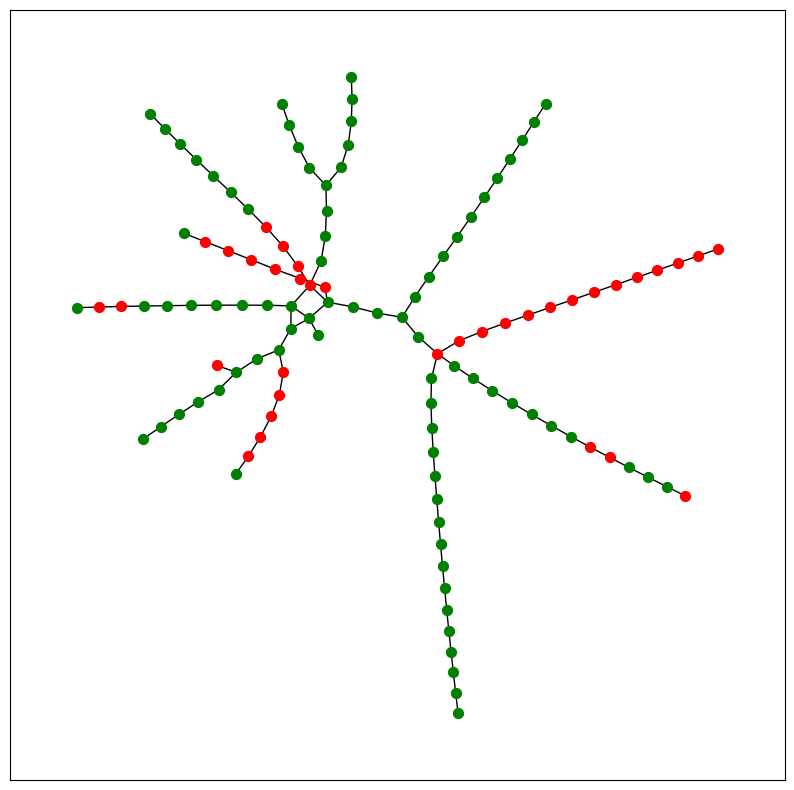

In [ ]:
# proof of concept for coloring nodes; for now just split into positive and negative delays
# later we can split into bins
nonnegative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay >= 0]
negative_delay_nodes = [n for (n, delay) in nx.get_node_attributes(network, "avg_delay").items() if delay < 0]
remaining_nodes = list(set(network.nodes()) - set(nonnegative_delay_nodes) - set(negative_delay_nodes))

fig = plt.figure(figsize = (10,10))
layout = nx.kamada_kawai_layout(network)
nx.draw_networkx_nodes(network, layout, nodelist=nonnegative_delay_nodes, node_color='red', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=negative_delay_nodes, node_color='green', node_size=50)
nx.draw_networkx_nodes(network, layout, nodelist=remaining_nodes, node_color='blue', node_size=50)
nx.draw_networkx_edges(network, layout)

In [2]:
avg_delay = nx.get_node_attributes(network, "avg_delay")

# Calculate the Katz centrality for each node
katz_centrality = nx.katz_centrality(network, alpha=0.1)


# Nothing compare the average delay with the Katz centrality for each node
for node in network.nodes():
    print(f"Node {node}:")
    print(f"  Average delay: {avg_delay[node]}")
    print(f"  Katz centrality: {katz_centrality[node]}")


print(avg_delay.values())

NameError: name 'network' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame(list(zip(avg_delay.values(), katz_centrality.values())), columns=["avg_delay", "katz_centrality"])

# Calculate the correlation coefficient between the two variables
correlation = df["avg_delay"].corr(df["katz_centrality"])

# Print the correlation coefficient
print(correlation)

# Create a scatter plot of the two variables
plt.scatter(df["avg_delay"], df["katz_centrality"])

# Show the plot
plt.show()